# Document for processors module

## 1. BaseProcessor
Abstract base-class for all preprocessing operators.

Sub-classes must implement :meth:`__call__` and are encouraged to keep a stateless, functional style. They can read or extend ``data.ctx`` for cross-stage communication, but should avoid storing large arrays for longer than absolutely necessary.

## 2. Time Window Processor
### Module path
FullWaveUST.processors.time_window

### Functionality
Apply a "Gaussian" taper to each time-domain waveform (time trace) to suppress signal discontinuities before and after the geometric time-of-flight (TOF).
- **Per‐channel windowing**: For each transmitter–receiver pair, compute its geometric TOF and center a smooth window there.
- **Smooth rise and decay**: Before TOF use a “pre‐window” half‐width, after TOF use a “post‐window” half‐width, avoiding hard edges that cause spectral leakage.
- **Configurable widths**: `pre_pct` and `post_pct` specify the pre‐ and post‐window widths as percentages of the maximum TOF.
- **In‐place operation**: Multiplies the window directly onto `data.array` without extra copies.

### Mathematical Description
Let
- $\(t\)$ be the time sample vector,
- $\(\mathrm{TOF}_{r,t}\)$ be the geometric time‐of‐flight for receiver $\(r\)$ and transmitter $\(t\)$,
- $\( \tau_{\mathrm{pre}} = \frac{\mathrm{pre\_pct}}{100}\,\max(\mathrm{TOF})\)$,
- $\( \tau_{\mathrm{post}} = \frac{\mathrm{post\_pct}}{100}\,\max(\mathrm{TOF})\)$.

The window function for channel $\((r,t)\)$ at time $\(t'\)$ is given by

$$
w_{r,t}(t')
= \exp\!\Biggl(
  -\tfrac12\Bigl[
    \frac{\max(0,\,t' - \mathrm{TOF}_{r,t})}{\tau_{\mathrm{post}}}
    + \frac{\max(0,\,\mathrm{TOF}_{r,t} - t')}{\tau_{\mathrm{pre}}}
  \Bigr]^2
\Biggr).
$$

Each time trace $\(x_{r,t}(t')\)$ is then multiplied in place:
$$
x^{\mathrm{win}}_{r,t}(t') = w_{r,t}(t') \;x_{r,t}(t').
$$


#### API
```TimeWindow(pre_pct: float = 5.0, post_pct: float | float("inf") = np.inf)```

pre_pct
- Percent (0–100) of ``max(TOF)`` used for the *leading* half window (default 5%).

post_pct
- Percent of ``max(TOF)`` for the *trailing* half window.  If set to ``np.inf`` the trace is not cut at the end (default).

#### Call
```
tw = TimeWindow(pre_pct=10.0, post_pct=20.0)
tw(data)
```

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from FullWaveUST.processors.time_window import TimeWindow
from FullWaveUST.data import AcquisitionData
from FullWaveUST.geometry import AcquisitionGeometry

In [12]:
# Generate Synthetic Test Data
# define time axis
T = 200
time = np.linspace(0, 1.0, T)    # 200 samples

# random Tx/Rx geometry
positions = np.random.rand(2, 3) * 100.0   # 3 transmitters, 2 rows [x; y]
c_geom    = 1540.0                         # propagation speed
acq_geom  = AcquisitionGeometry(positions, c_geom)

# compute TOF and reorder to (Tx, Rx)
tof = acq_geom.compute_geometric_tofs()
Tx, Rx = tof.shape

# build raw data directly in shape (Tx, Rx, T)
raw = np.zeros((Tx, Rx, T))
for tx in range(Tx):
    for rx in range(Rx):
        # find nearest time sample to this channel's TOF
        idx = np.argmin(np.abs(time - tof[tx, rx]))
        raw[tx, rx, idx] = 1.0

# add noise
raw += 0.05 * np.random.randn(Tx, Rx, T)

# wrap into AcquisitionData
data = AcquisitionData(
    time=time,
    array=raw.copy(),
    geometry= acq_geom
)

print(f"Generated data.array shape: {data.array.shape}")

Generated data.array shape: (3, 3, 200)


In [13]:
# Apply Time Window Processor
processor = TimeWindow(pre_pct=10, post_pct=10)
processor(data)

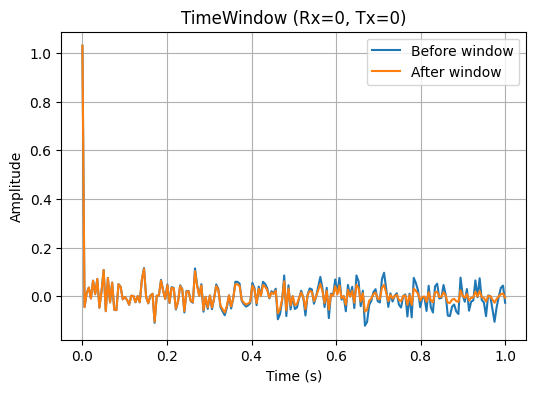

In [14]:
# pick receiver 0, transmitter 0
tx0, rx0 = 0, 0

plt.figure(figsize=(6,4))
plt.plot(time, raw[tx0, rx0, :], label='Before window')
plt.plot(time, data.array[tx0, rx0, :], label='After window')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'TimeWindow (Rx={rx0}, Tx={tx0})')
plt.legend()
plt.grid(True)
plt.show()

## 3. DTFT Processor
### Module path
FullWaveUST.processors.dtft

### Functionality
It performs the discrete-time Fourier transform (DTFT) at user-specified frequencies.
- **Frequency projection**
  Converts each time-series $\(x_{r,t}(t_n)\)$ into its spectrum $\(X_{r,t}(f_k)\)$ at user-chosen frequencies $\(f_k\)$.
- **In-place replacement**  
  Overwrites `data.array` with the complex spectrum and stores the frequency vector in `data.freqs`.

### Mathematical Description
Given
- $\(t_n,\;n=0\ldots T-1\)$ (time samples)
- $\(\Delta t = t_{n+1}-t_n\)$ (assumed uniform)
- $\(x_{r,t}(t_n)\)$ (time trace for receiver $\(r\)$, transmitter $\(t\)$)
- target frequencies $\(f_k,\;k=0\ldots F-1\)$

the discrete-time Fourier transform is

$$
X_{r,t}(f_k)
= \sum_{n=0}^{T-1}
  x_{r,t}(t_n)\;\exp\bigl(-i\,2\pi\,f_k\,t_n\bigr)\;\Delta t.
$$

After computing, the array shape goes from
$$
\((T, R_x, T_x)\) → \((T_x, R_x, F)\).
$$

#### API
```DTFT(freqs: np.ndarray)```

freqs
- One-dimensional array with the target frequencies in Hz.

#### Call
```
dtft = DTFT(freqs)
dtft(data)
```

Reads
- data.array of shape (Tx, Rx, T) (time‐domain traces)
- data.time: 1D time vector of length T

Writes
- Replaces data.array with its DTFT of shape (Tx, Rx, F)
- Sets data.freqs to the input freqs array

Spectrum shape: (3, 3, 256)


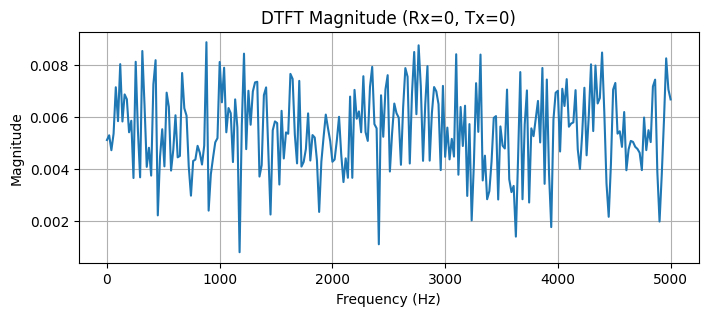

In [15]:
from FullWaveUST.processors.dtft import DTFT
# Choose frequencies
freqs = np.linspace(0, 5e3, 256)  # 0–5000 Hz

# Apply DTFT
dtft = DTFT(freqs)
dtft(data)

# Inspect shapes
print("Spectrum shape:", data.array.shape)  # (Tx, Rx, F)

# Plot magnitude spectrum for Rx=0, Tx=0
spectrum = data.array[0, 0, :]  # pick Tx=0, Rx=0
plt.figure(figsize=(8,3))
plt.plot(freqs, np.abs(spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('DTFT Magnitude (Rx=0, Tx=0)')
plt.grid(True)
plt.show()

## 4. PhaseScreenCorrection
### Moudle Path
`FullWaveUST.processors.phase_screen`


### Functionality
In full‐waveform ultrasound tomography, each transducer element is often “snapped” to the nearest grid node to simplify computations.  This snapping introduces a systematic phase error because the time‐of‐flight (TOF) from the snapped position differs from the true continuous‐space TOF.

`PhaseScreenCorrection` removes this error by multiplying each frequency-domain trace by a complex-valued phase correction factor computed from time-of-flight discrepancies.


### Mathematical Description
Let
- $\(s\)$ index a transmitter element,
- $\(r\)$ index a receiver element,
- $\(f\)$ be angular frequency components,
- $\(c_0\)$ be the reference sound speed.

Define two TOFs:
1. **True TOF**
   $$
     \mathrm{TOF}^{\mathrm{true}}_{sr}
     = \frac{\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2}}{c_0},
   $$
   where $\((x_s,y_s)\)$ and $\((x_r,y_r)\)$ are the exact coordinates.

2. **Discrete (Snapped) TOF**
   $$
     \mathrm{TOF}^{\mathrm{disc}}_{sr}
     = \frac{\sqrt{(X_s - X_r)^2 + (Y_s - Y_r)^2}}{c_0},
   $$
   where $\((X_s,Y_s)\)$ and $\((X_r,Y_r)\)$ are the nearest grid‐node coordinates.

The phase‐screen correction factor for each channel $\((s,r)\)$ and frequency $\(f\)$ is

$$
  \mathrm{PS}_{sr}(f)
  = \exp\!\Bigl[
      i\,\sigma\,2\pi\,f\,\bigl(\mathrm{TOF}^{\mathrm{disc}}_{sr}
      - \mathrm{TOF}^{\mathrm{true}}_{sr}\bigr)
    \Bigr],
$$

where $\(\sigma \in \{+1,-1\}\)$ sets the $\(e^{\pm i\omega t}\)$ sign convention.  Multiplying the measured spectrum $\(X_{sr}(f)\)$ by $\(\mathrm{PS}_{sr}(f)\)$ cancels the snapping‐induced phase error.


#### API
```PhaseScreenCorrection(image_geometry: ImageGeometry, sign: int = -1)```

image_geometry
- An class:`ImageGeometry`, instance that defines the reconstruction grid.

- sign : {+1, −1}, optional, Sign convention used by the Helmholtz solver (default −1 → `e^{-jωt}`).

#### Call
psc = PhaseScreenCorrection(image_geometry=img_geom, sign=-1)
psc(data)

Reads
- data.array of shape (Tx, Rx, F) (frequency‐domain spectrum)
- data.freqs: 1D array of length F
- data.geometry.positions: transmitter/receiver coordinates
- data.geometry.c_geom: reference propagation speed

Writes
- Modifies data.array in place by multiplying each (Tx,Rx) trace by its phase‐screen factor.
- data.ctx[“x_idx”] = array of transmitter→grid‐x indices (ix)
- data.ctx[“y_idx”] = array of transmitter→grid‐y indices (iy)
- data.ctx[“grid_lin_idx”] = flattened linear index of each snapped transmitter in the grid

Demo: PhaseScreenCorrection on a Coarse Grid

In this example we use a very coarse reconstruction grid so that snapping each element to its nearest node produces a noticeable TOF error and thus a visible phase correction.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from FullWaveUST.geometry.acquisition_geometry import AcquisitionGeometry
from FullWaveUST.geometry.image_geometry       import ImageGeometry
from FullWaveUST.data.acquisition_data         import AcquisitionData
from FullWaveUST.processors.phase_screen       import PhaseScreenCorrection

# Generate 5 random transducer positions (true coords)
np.random.seed(0)
positions = np.random.rand(2, 5) * 100.0   # shape (2,5)
c_geom    = 1540.0
acq_geom  = AcquisitionGeometry(positions, c_geom)
print('transducer positions:')
print(positions)

transducer positions:
[[54.88135039 71.51893664 60.27633761 54.4883183  42.36547993]
 [64.58941131 43.75872113 89.17730008 96.36627605 38.34415188]]


In [2]:
# Build a very coarse 3×2 image grid for snapping
xi = np.linspace(positions[0].min(), positions[0].max(), 3)
yi = np.linspace(positions[1].min(), positions[1].max(), 2)
img_geom = ImageGeometry(xi, yi)
print(xi)
print(yi)

[42.36547993 56.94220829 71.51893664]
[38.34415188 96.36627605]


In [3]:
# Define frequency axis
F = 256
freqs = np.linspace(3000, 5000, F)

# Compute true TOFs and build “uncorrected” spectrum:
#     spec_uncorr[s,r,f] = exp(j*2π * TOF_true[s,r] * f)
tof_true     = acq_geom.compute_geometric_tofs().T   # shape (Tx, Rx)
spec_uncorr  = np.exp(1j * 2*np.pi * tof_true[:, :, None] * freqs[None, None, :])

# Wrap into AcquisitionData (freq-domain)
acq_data = AcquisitionData(array=spec_uncorr.copy(),
                           freqs=freqs,
                           geometry=acq_geom)

# Instantiate and apply PhaseScreenCorrection
psc = PhaseScreenCorrection(image_geometry=img_geom, sign=-1)
psc(acq_data)

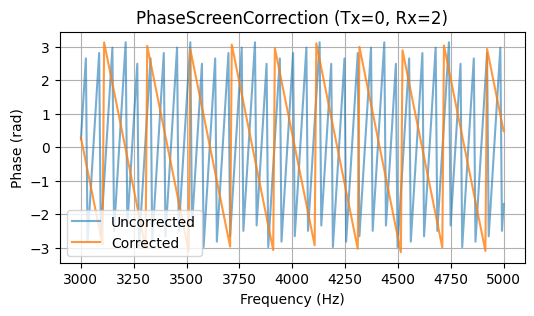

Mean phase shift: -0.090 rad
Max  phase shift: 5.664 rad


In [4]:
# Plot Uncorrected vs. Corrected phase for Tx=0, Rx=1
phase_u = np.angle(spec_uncorr[0, 2, :])
phase_c = np.angle(acq_data.array[0, 2, :])

plt.figure(figsize=(6,3))
plt.plot(freqs, phase_u, label='Uncorrected', alpha=0.6)
plt.plot(freqs, phase_c, label='Corrected',   alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')
plt.title('PhaseScreenCorrection (Tx=0, Rx=2)')
plt.legend()
plt.grid(True)
plt.show()

# 5.8 Print phase‐shift statistics
delta_phase = phase_c - phase_u
print(f"Mean phase shift: {delta_phase.mean():.3f} rad")
print(f"Max  phase shift: {delta_phase.max():.3f} rad")

## 5. Downsample Processor
#### Module Path
`FullWaveUST.processors.downsample`


#### Functionality
Reduce computational load by subsampling the transmitter axis: keep only every *k*-th Tx channel.

- **Subsampling**
  Retains transmitters at indices `[0, step, 2·step, …]`, discarding the rest.
- **Context storage**
  Saves the retained Tx indices in `data.ctx["tx_keep"]` for downstream solvers or adjoint sources.
- **NaN handling**
  Replaces any NaNs in the subsampled data with zero.


#### API
```DownSample(step: int = 1)```

step
- Subsampling factor along the transmitter axis.  Must be ≥ 1; keeps every step-th Tx channel.

#### Call
```
ds = DownSample(step=2)
ds(data)
```

Reads
- data.array of shape (Tx, Rx, T) or (Tx, Rx, F)

Writes
- Replaces data.array with data.array[tx_keep, :, :]
- Stores the kept transmitter indices in data.ctx["tx_keep"]



In [6]:
# demo
from FullWaveUST.processors.down_sample import DownSample

data = acq_data
print("Original data.array.shape:", data.array.shape)

# Downsample by keeping every 2nd Tx
ds = DownSample(step=2)
ds(data)

print("\nAfter DownSample(step=2):")
print("  data.array.shape:", data.array.shape)
print("  data.ctx['tx_keep']:", data.ctx["tx_keep"])

Original data.array.shape: (3, 5, 256)

After DownSample(step=2):
  data.array.shape: (2, 5, 256)
  data.ctx['tx_keep']: [0 2]


## 6. AcceptanceMask Processor
#### Module Path
`FullWaveUST.processors.acceptance_mask`

#### Functionality
Exclude receivers that are “too close” in index space to each transmitter, by building a circular‐index mask of shape `(N, N)` where `N` is the number of elements.
- For each transmitter index `tx` (0 ≤ tx < N), define a circular exclusion zone of radius `delta` in index units.
- All receivers `rx` with circular distance |rx–tx| ≤ `delta` (mod N) are **excluded** (`False` in the mask); others are **kept** (`True`).
- The boolean mask is stored in `data.ctx["elem_mask"]` for downstream processors to zero out or skip channels.


#### API
```AcceptanceMask(delta: int = 63)```

delta
- int, default 63. Exclusion radius in element‐index units.

#### Call
```
am = AcceptanceMask(delta=2)
am(data)
```

Reads
- data.geometry.n_elements: number of Tx/Rx elements

Writes
- data.ctx["elem_mask"]: boolean array of shape (N, N)

Demo
Below we create a synthetic AcquisitionData with 10 elements, apply AcceptanceMask with delta=2, and visualize the mask for transmitter 0 and 5.

Mask shape: (10, 10)
Mask for Tx=0: [False False False  True  True  True  True  True False False]
Mask for Tx=5: [ True  True  True False False False False False  True  True]


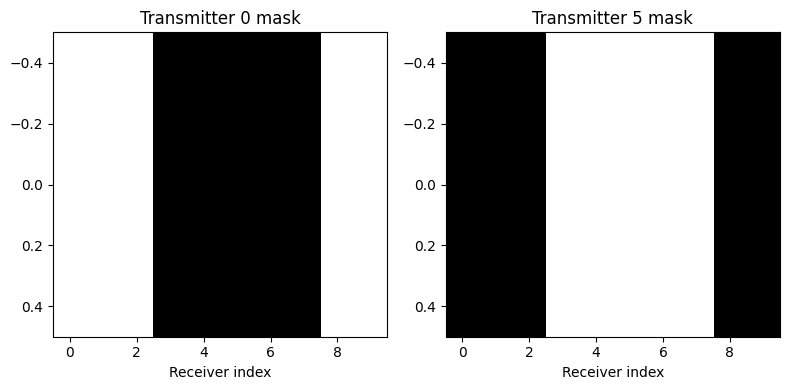

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from FullWaveUST.geometry.acquisition_geometry import AcquisitionGeometry
from FullWaveUST.data.acquisition_data         import AcquisitionData
from FullWaveUST.processors.acceptance_mask    import AcceptanceMask

# Create a dummy 10-element circular array
N = 10
positions = np.stack([
    np.cos(2*np.pi*np.arange(N)/N),
    np.sin(2*np.pi*np.arange(N)/N)
], axis=0)  # circle of radius 1
acq_geom = AcquisitionGeometry(positions, c_geom=1500.0)

# Build dummy data array (Tx, Rx, T)
T = 50
time = np.linspace(0, 1.0, T)
raw = np.random.randn(N, N, T)  # full Tx×Rx grid
data = AcquisitionData(array=raw.copy(), time=time, geometry=acq_geom)

# Apply AcceptanceMask with delta=2
mask_proc = AcceptanceMask(delta=2)
mask_proc(data)

# Inspect the stored mask
mask = data.ctx["elem_mask"]  # shape (N, N)
print("Mask shape:", mask.shape)
print("Mask for Tx=0:", mask[0])
print("Mask for Tx=5:", mask[5])

# Visualize mask entries
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(mask[0][None, :], aspect='auto', cmap='gray_r')
axes[0].set_title("Transmitter 0 mask")
axes[0].set_xlabel("Receiver index")
axes[1].imshow(mask[5][None, :], aspect='auto', cmap='gray_r')
axes[1].set_title("Transmitter 5 mask")
axes[1].set_xlabel("Receiver index")
plt.tight_layout()
plt.show()

## 7. MagnitudeOutlierFilter
#### Module Path
`FullWaveUST.processors.outlier_removal`
#### Class
`MagnitudeOutlierFilter`


#### Functionality
Zero out the largest‐magnitude samples in each (Tx,Rx) frequency slice, limited to the valid channels defined by an acceptance mask.

This filter helps suppress spurious high‐amplitude outliers (e.g. noise spikes) before further processing.  It uses a precomputed boolean mask `data.ctx["elem_mask"]` (from `AcceptanceMask`) and optional Tx‐downsampling indices `data.ctx["tx_keep"]` to restrict which channels are considered.


#### Mathematical Description

Let
- $\(X_{sr}(f)\)$ be the complex spectrum at transmitter *s*, receiver *r*, frequency *f*.
- $\(M_{sr}(f) = |X_{sr}(f)|\)$ its magnitude.
- $\(\mathcal{S}\subset\{(s,r)\}\)$ the set of valid channels (from the acceptance mask and downsampling).
- $\(N = |\mathcal{S}|\)$.
- $\(\alpha=\)$ keep_fraction (e.g. 0.99).
- $\(K = \lceil(1-\alpha)\,N\rceil\)$.

Define the cutoff
$$
  \tau(f) = \text{the $K$-th largest value among }\{M_{sr}(f)\mid(s,r)\in\mathcal{S}\}.
$$
Then the filter sets
$$
  X_{sr}(f)\gets 0
  \quad\text{whenever}\quad
  (s,r)\in\mathcal{S}
  \;\text{and}\;
  M_{sr}(f)\ge\tau(f),
$$
leaving other entries unchanged.

#### API
```MagnitudeOutlierFilter(threshold: float = 0.99)```

threshold : fraction (\alpha\in(0,1]) of smallest magnitudes to keep.
0.99 (default) ⇒ drop the top 1% largest values in each slice.

#### Call
```
filter = MagnitudeOutlierFilter(threshold=0.95)
filter(data)
```
Reads:
- data.array of shape (Tx, Rx, F)
- data.ctx["elem_mask"] (bool mask (Tx_full, Rx)) if exists
- data.ctx["tx_keep"] (int indices into Tx) if exists

Writes:
- data.array with outliers zeroed in place.

elem_mask shape: (6, 6)
tx_keep: [0 2 4]
array shape after downsample: (3, 6, 50)


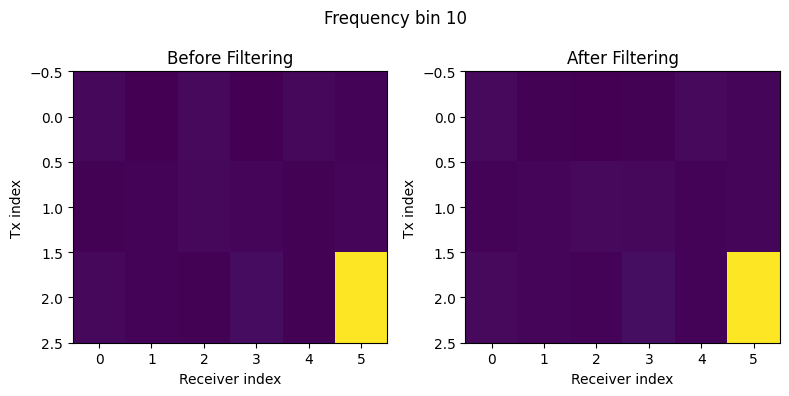

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from FullWaveUST.geometry.acquisition_geometry import AcquisitionGeometry
from FullWaveUST.data.acquisition_data         import AcquisitionData
from FullWaveUST.processors.acceptance_mask    import AcceptanceMask
from FullWaveUST.processors.down_sample         import DownSample
from FullWaveUST.processors.outlier_removal    import MagnitudeOutlierFilter

# Parameters
N = 6    # number of elements (Tx and Rx)
F = 50   # number of frequency bins

# Geometry and dummy spectrum
positions = np.random.rand(2, N) * 100.0
geom = AcquisitionGeometry(positions, c_geom=1500.0)
freqs = np.linspace(0, 1000, F)

# build a spectrum of shape (Tx, Rx, F) = (N, N, F)
spec = 0.1*(np.random.randn(N, N, F) + 1j*np.random.randn(N, N, F))
# inject two outliers at frequency index 10
spec[1, 2, 10] = 10 + 0j
spec[4, 5, 10] = -8 + 0j

data = AcquisitionData(array=spec.copy(), time=None, geometry=geom)
data.freqs = freqs

# Apply AcceptanceMask (exclude ±1 neighbors)
am = AcceptanceMask(delta=1)
am(data)
print("elem_mask shape:", data.ctx["elem_mask"].shape)

# Downsample Tx (keep every 2nd)
ds = DownSample(step=2)
ds(data)
print("tx_keep:", data.ctx["tx_keep"])
print("array shape after downsample:", data.array.shape)

# Outlier removal (keep 95%)
of = MagnitudeOutlierFilter(threshold=0.95)
of(data)

# Visualize before & after at f=10
f_idx = 10
# before: apply tx_keep to original spec
before = np.abs(spec[data.ctx["tx_keep"], :, f_idx])
after  = np.abs(data.array[:, :, f_idx])

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(before, aspect='auto', cmap='viridis')
axes[0].set_title("Before Filtering")
axes[1].imshow(after, aspect='auto', cmap='viridis')
axes[1].set_title("After Filtering")
for ax in axes:
    ax.set_xlabel("Receiver index")
    ax.set_ylabel("Tx index")
plt.suptitle(f"Frequency bin {f_idx}")
plt.tight_layout()
plt.show()

## 8.Pipeline

#### Module Path
`FullWaveUST.pipeline`
#### Class
`Pipeline`

#### Purpose
Execute a sequence of `BaseProcessor` stages on a single `AcquisitionData` instance, threading it through each stage in place to keep memory usage constant.




#### API
```
Pipeline(
    stages: Iterable[BaseProcessor],
    *,
    verbose: bool = False,
    logger: Optional[logging.Logger] = None
)
````
stages:
- an iterable of processor instances (e.g. TimeWindow(), DTFT(freqs), etc.)

verbose:
- if True, prints progress messages to stdout

logger:
- if set, messages are sent to logger.info(...) instead of stdout


Demo
Below we build a small pipeline to window in time, transform to frequency, downsample Tx, and apply an acceptance mask and outlier filter.

In [1]:
import numpy as np
from FullWaveUST.geometry  import AcquisitionGeometry
from FullWaveUST.data        import AcquisitionData
from FullWaveUST.processors      import TimeWindow, DTFT, DownSample, AcceptanceMask, MagnitudeOutlierFilter
from FullWaveUST.processors                     import Pipeline

# Synthetic acquisition data
T = 100
time = np.linspace(0, 1.0, T)
positions = np.stack([np.linspace(0,50,6), np.zeros(6)], axis=0)
geom = AcquisitionGeometry(positions, c_geom=1500.0)
raw = np.random.randn(6, 6, T)  # shape (Tx=6, Rx=6, T)
data = AcquisitionData(array=raw.copy(), time=time, geometry=geom)

# Build pipeline
freqs = np.linspace(0, 5000, 128)
pipeline = Pipeline(
    stages=[
        TimeWindow(pre_pct=10, post_pct=10),
        DTFT(freqs),
        DownSample(step=2),
        AcceptanceMask(delta=1),
        MagnitudeOutlierFilter(threshold=0.95),
    ],
    verbose=True
)

# Run
result = pipeline(data)

# Inspect
print("Final array shape:", result.array.shape)  # (Tx/2, Rx, F)
print("Context keys:", result.ctx.keys())

[01/5] TimeWindow …
    done in  0.000 s
[02/5] DTFT …
    done in  0.001 s
[03/5] DownSample …
    done in  0.000 s
[04/5] AcceptanceMask …
    done in  0.000 s
[05/5] MagnitudeOutlierFilter …
    done in  0.002 s
Final array shape: (3, 6, 128)
Context keys: dict_keys(['tx_keep', 'elem_mask'])
